In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/responsive-ai'

/content/drive/MyDrive/responsive-ai


## Dependencies

In [ ]:
!pip install quantus
!pip install captum==0.7.0
!pip install ptflops
!pip install rtdl_revisiting_models

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import shap
import quantus
import pickle
from tqdm import tqdm
import time

# Data

## Loading

In [ ]:
X, y = shap.datasets.adult(display=True)

## Preprocessing

In [ ]:
X_enc = X.copy()
cat_cols = X_enc.select_dtypes(['object','category']).columns
cardinalities = []
label_mappings = {}
for col in cat_cols:
    le = LabelEncoder()
    X_enc[col] = le.fit_transform(X_enc[col])
    cardinalities.append(len(le.classes_))
    label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

num_cols = [c for c in X_enc.columns if c not in cat_cols]

In [ ]:
for col, mapping in label_mappings.items():
    print(f"\nEncoded mapping for '{col}':")
    for original, encoded in mapping.items():
        print(f"  {original} → {encoded}")


Encoded mapping for 'Workclass':
   ? → 0
   Federal-gov → 1
   Local-gov → 2
   Never-worked → 3
   Private → 4
   Self-emp-inc → 5
   Self-emp-not-inc → 6
   State-gov → 7
   Without-pay → 8

Encoded mapping for 'Marital Status':
   Divorced → 0
   Married-AF-spouse → 1
   Married-civ-spouse → 2
   Married-spouse-absent → 3
   Never-married → 4
   Separated → 5
   Widowed → 6

Encoded mapping for 'Occupation':
   ? → 0
   Adm-clerical → 1
   Armed-Forces → 2
   Craft-repair → 3
   Exec-managerial → 4
   Farming-fishing → 5
   Handlers-cleaners → 6
   Machine-op-inspct → 7
   Other-service → 8
   Priv-house-serv → 9
   Prof-specialty → 10
   Protective-serv → 11
   Sales → 12
   Tech-support → 13
   Transport-moving → 14

Encoded mapping for 'Relationship':
   Husband → 0
   Not-in-family → 1
   Other-relative → 2
   Own-child → 3
   Unmarried → 4
   Wife → 5

Encoded mapping for 'Race':
   Amer-Indian-Eskimo → 0
   Asian-Pac-Islander → 1
   Black → 2
   Other → 3
   White → 4

Encod

In [ ]:
print(f"\nCardinalities of categorical columns: {cardinalities}")


Cardinalities of categorical columns: [9, 7, 15, 6, 5, 2, 42]


## Splitting and Formatting

In [ ]:
# Train/test split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_enc, y, test_size=0.2, random_state=7, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=7, stratify=y_trainval
)

# Convert to numpy / tensors
X_train_num = X_train[num_cols].to_numpy(dtype=np.float32)
X_val_num   = X_val[num_cols].to_numpy(dtype=np.float32)
X_test_num  = X_test[num_cols].to_numpy(dtype=np.float32)

X_train_cat = X_train[cat_cols].to_numpy(dtype=np.int64)
X_val_cat   = X_val[cat_cols].to_numpy(dtype=np.int64)
X_test_cat  = X_test[cat_cols].to_numpy(dtype=np.int64)

y_train_np = y_train.astype(np.int64).values if isinstance(y_train, pd.Series) else y_train.astype(np.int64)
y_val_np   = y_val.astype(np.int64).values if isinstance(y_val, pd.Series) else y_val.astype(np.int64)
y_test_np = y_test.astype(np.int64).values if isinstance(y_test, pd.Series) else y_test.astype(np.int64)

X_train_num_t = torch.from_numpy(X_train_num)
X_train_cat_t = torch.from_numpy(X_train_cat)
X_val_num_t = torch.from_numpy(X_val_num)
X_val_cat_t = torch.from_numpy(X_val_cat)
X_test_num_t = torch.from_numpy(X_test_num)
X_test_cat_t = torch.from_numpy(X_test_cat)

y_train_t = torch.from_numpy(y_train_np)
y_val_t   = torch.from_numpy(y_val_np)
y_test_t  = torch.from_numpy(y_test_np)


## Dataloaders

In [ ]:
batch_size = 32
train_ds = TensorDataset(
    torch.from_numpy(X_train_num),
    torch.from_numpy(X_train_cat),
    y_train_t
)
val_ds = TensorDataset(
    torch.from_numpy(X_val_num),
    torch.from_numpy(X_val_cat),
    y_val_t
)
test_ds = TensorDataset(
    torch.from_numpy(X_test_num),
    torch.from_numpy(X_test_cat),
    y_test_t
)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)


# FTTransformer model

In [ ]:
from rtdl_revisiting_models import FTTransformer

# Input dims
d_num = X_train_num.shape[1]
cat_cardinalities = cardinalities
n_cont_features = len(num_cols)
d_out = 2

default_kwargs = FTTransformer.get_default_kwargs()
# default_kwargs['n_blocks'] = 2
default_kwargs['d_block'] = 32
default_kwargs['attention_n_heads'] = 1
# default_kwargs['attention_dropout'] = 0.2   # originally ~0.1
# default_kwargs['ffn_dropout']       = 0.2   # originally ~0.1
# default_kwargs['residual_dropout']  = 0.2   # originally 0.0 or tiny

model = FTTransformer(
    n_cont_features=n_cont_features,
    cat_cardinalities=cat_cardinalities,
    d_out=d_out,
    **default_kwargs,
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FTTransformer(
  (cls_embedding): _CLSEmbedding()
  (cont_embeddings): LinearEmbeddings()
  (cat_embeddings): CategoricalEmbeddings(
    (embeddings): ModuleList(
      (0): Embedding(9, 32)
      (1): Embedding(7, 32)
      (2): Embedding(15, 32)
      (3): Embedding(6, 32)
      (4): Embedding(5, 32)
      (5): Embedding(2, 32)
      (6): Embedding(42, 32)
    )
  )
  (backbone): FTTransformerBackbone(
    (blocks): ModuleList(
      (0): ModuleDict(
        (attention): MultiheadAttention(
          (W_q): Linear(in_features=32, out_features=32, bias=True)
          (W_k): Linear(in_features=32, out_features=32, bias=True)
          (W_v): Linear(in_features=32, out_features=32, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (attention_residual_dropout): Dropout(p=0.0, inplace=False)
        (ffn_normalization): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (ffn): Sequential(
          (linear1): Linear(in_features=32, out_features=84,

# Training & Eval

## Training

In [ ]:
X_train_num_t = X_train_num_t.to(device)
X_train_cat_t = X_train_cat_t.to(device)
X_val_num_t = X_val_num_t.to(device)
X_val_cat_t = X_val_cat_t.to(device)
X_test_num_t = X_test_num_t.to(device)
X_test_cat_t = X_test_cat_t.to(device)

y_train_t = y_train_t.to(device)
y_val_t   = y_val_t.to(device)
y_test_t  = y_test_t .to(device)

best_val_loss = float('inf')
patience   = 20
epochs_no_improve = 0


num_epochs = 400

start_time = time.time()
for epoch in range(num_epochs):
    # ---- training step ----
    model.train()

    logits = model(X_train_num_t, X_train_cat_t)                    # (batch_size, 2)
    loss = criterion(logits, y_train_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_train_pred = torch.argmax(logits, dim=1)
    train_accuracy = accuracy_score(y_train_t.cpu().numpy(), y_train_pred.cpu().numpy())

    # ---- validation step ----
    model.eval()
    with torch.no_grad():
        val_logits = model(X_val_num_t, X_val_cat_t)
        val_loss = criterion(val_logits, y_val_t)
        val_pred = torch.argmax(val_logits, dim=1)
        val_accuracy = accuracy_score(y_val_t.cpu().numpy(), val_pred.cpu().numpy())

    if ((epoch + 1) % 50) == 0 or (epoch + 1 == 1):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Training Loss: {loss.item():.4f}   - Training Accuracy: {train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss.item():.4f} - Validation Accuracy: {val_accuracy:.4f} \n")

    # ---- check for improvement ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs.")
            break

# Evaluate on test data
model.eval()
with torch.no_grad():
    logits = model(X_test_num_t, X_test_cat_t)
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)
    accuracy = (preds == y_test_t).float().mean().item()
    print(f"\nTest Accuracy: {accuracy:.4f}")


end_time = time.time()
elapsed_time = end_time - start_time


Epoch [1/400]
Training Loss: 0.6751   - Training Accuracy: 0.6098
Validation Loss: 0.5714 - Validation Accuracy: 0.7593 

Epoch [50/400]
Training Loss: 0.3877   - Training Accuracy: 0.8154
Validation Loss: 0.3771 - Validation Accuracy: 0.8202 

Epoch [100/400]
Training Loss: 0.3368   - Training Accuracy: 0.8434
Validation Loss: 0.3478 - Validation Accuracy: 0.8445 


Early stopping triggered after 113 epochs.

Test Accuracy: 0.8455


In [ ]:
print("\nTotal training time: ", elapsed_time)


Total training time:  13.455175638198853


In [ ]:
# Saving the model
torch.save(model.state_dict(), "saved_model/fttransformer_adults.pth")

## Eval

In [ ]:
# Loading the model
model.load_state_dict(torch.load("saved_model/fttransformer_adults.pth"))

<All keys matched successfully>

In [ ]:
X_test_num_t = X_test_num_t.to(device)
X_test_cat_t = X_test_cat_t.to(device)
y_test_t  = y_test_t .to(device)
model.eval()
with torch.no_grad():
    logits = model(X_test_num_t, X_test_cat_t)
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)
    accuracy = (preds == y_test_t).float().mean().item()
    print(f"\nTest Accuracy: {accuracy:.4f}")


Test Accuracy: 0.8455


## Training with bs

In [ ]:
best_val_loss = float('inf')
best_epoch    = -1
patience   = 20
epochs_no_improve = 0
best_state_dict = None
num_epochs = 100

start_time = time.time()
for epoch in range(1, num_epochs+1):
    # ---- training step ----
    model.train()
    total_loss = 0
    all_preds, all_targets = [], []

    for Xn, Xc, yb in tqdm(train_loader, desc=f"Epoch {epoch:02d} [Train]", leave=False):
        Xn, Xc, yb = Xn.to(device), Xc.to(device), yb.to(device)
        logits = model(Xn, Xc)                    # (batch_size, 2)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * Xn.size(0)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.cpu().numpy())

    # Epoch metrics
    train_loss = total_loss / len(train_loader.dataset)
    train_acc  = accuracy_score(
        np.concatenate(all_targets), np.concatenate(all_preds)
    )

    # ---- validation step ----
    model.eval()
    total_val_loss = 0.0
    all_val_preds, all_val_targs = [], []
    with torch.no_grad():
        for Xn_val, Xc_val, yb_val in tqdm(val_loader, desc=f"Epoch {epoch:02d} [Validate]", leave=False):
            Xn_val = Xn_val.to(device)
            Xc_val = Xc_val.to(device)
            yb_val = yb_val.to(device)

            logits_val = model(Xn_val, Xc_val)
            loss_val = criterion(logits_val, yb_val)

            total_val_loss += loss_val.item() * Xn_val.size(0)
            preds_val = logits_val.argmax(dim=1).cpu().numpy()
            all_val_preds.append(preds_val)
            all_val_targs.append(yb_val.cpu().numpy())

    val_loss = total_val_loss / len(val_loader.dataset)
    val_acc  = accuracy_score(np.concatenate(all_val_targs), np.concatenate(all_val_preds))

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d}  Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}  Val Acc: {val_acc:.4f}")

    # ---- check for improvement ----
    if val_loss < best_val_loss - 1e-5:
        best_val_loss = val_loss
        best_epoch = epoch
        epochs_no_improve = 0
        best_state_dict = model.state_dict()  # save best weights
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered! No improvement in {patience} epochs.")
            break

end_time = time.time()
elapsed_time = end_time - start_time
print("\nTotal training time: ", elapsed_time)

if best_state_dict is not None:
    model.load_state_dict(best_state_dict)

Epoch 01  Loss: 0.3151  Train Acc: 0.8518  Val Acc: 0.8493


Epoch 10  Loss: 0.3110  Train Acc: 0.8547  Val Acc: 0.8549


Epoch 20  Loss: 0.3057  Train Acc: 0.8554  Val Acc: 0.8499


Epoch 30  Loss: 0.2999  Train Acc: 0.8567  Val Acc: 0.8528


Epoch 40  Loss: 0.3118  Train Acc: 0.8511  Val Acc: 0.8545



Early stopping triggered! No improvement in 20 epochs.

Total training time:  389.5426354408264


## Eval with bs

In [ ]:
# Loading the model
model.load_state_dict(torch.load("saved_model/fttransformer_adults.pth"))

<All keys matched successfully>

In [ ]:
# 6. Evaluation on Test Set
model.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for Xn, Xc, yb in tqdm(test_loader, desc="Testing", leave=False):
        Xn, Xc = Xn.to(device), Xc.to(device)
        logits = model(Xn, Xc)
        test_preds.append(logits.argmax(dim=1).cpu().numpy())
        test_targets.append(yb.numpy())

test_acc = accuracy_score(
    np.concatenate(test_targets),
    np.concatenate(test_preds)
)
print(f"FT-Transformer Test Accuracy: {test_acc:.4f}")


FT-Transformer Test Accuracy: 0.8455


In [ ]:
# Saving the model
torch.save(model.state_dict(), "saved_model/fttransformer_adults.pth")

# Sustainability

## Param Count

In [ ]:
# Parameter Count (Pure PyTorch)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Usage
total_params = count_parameters(model)
print(f"Trainable parameters: {total_params:,}")

Trainable parameters: 25,726


## FLOPs

In [ ]:
# Calculate FLOPS
from torch.utils.flop_counter import FlopCounterMode

X_test_num_torch = torch.from_numpy(X_test_num).to(device)    # float32 tensor, shape (n_test, n_cont)
X_test_cat_torch = torch.from_numpy(X_test_cat).to(device)

sample_num    = X_test_num_torch[0:1]  # shape (1, n_cont)
sample_cat    = X_test_cat_torch[0:1]  # shape (1, n_cat)

model.eval()
with FlopCounterMode() as flop_counter:
    _ = model(sample_num, sample_cat)

flops_per_sample = flop_counter.get_total_flops()
print(f"FLOPs per sample: {flops_per_sample/1e3:.2f} K")
print(f"FLOPs: {flops_per_sample*X_test_num_torch.shape[0]/1e6:.2f}M")

Module                       FLOP    % Total
-----------------------  --------  ---------
FTTransformer            574.592K    100.00%
 - aten.addmm            529.664K     92.18%
 - aten.bmm               44.928K      7.82%
 FTTransformer.backbone  574.592K    100.00%
  - aten.addmm           529.664K     92.18%
  - aten.bmm              44.928K      7.82%
FLOPs per sample: 574.59 K
FLOPs: 3742.32M


## MACs

In [ ]:
n_cont = X_test_num.shape[1]
n_cat  = X_test_cat.shape[1]
cat_cardinalities = cardinalities  # list of ints, one per categorical column

class FTTransformerSingleInput(nn.Module):
    def __init__(self, ft_model, n_cont, n_cat, cat_cardinalities):
        super().__init__()
        self.ft = ft_model
        self.n_cont = n_cont
        self.n_cat = n_cat
        self.cat_cardinalities = cat_cardinalities

    def forward(self, x_combined):
        x_num = x_combined[:, : self.n_cont].float()
        x_cat = x_combined[:, self.n_cont : self.n_cont + self.n_cat].long()
        # Clip to valid category range:
        for i, card in enumerate(self.cat_cardinalities):
            x_cat[:, i] = torch.clamp(x_cat[:, i], 0, card - 1)
        return self.ft(x_num, x_cat)

wrapped = FTTransformerSingleInput(model, n_cont, n_cat, cat_cardinalities)
wrapped.to(device)
wrapped.eval()

FTTransformerSingleInput(
  (ft): FTTransformer(
    (cls_embedding): _CLSEmbedding()
    (cont_embeddings): LinearEmbeddings()
    (cat_embeddings): CategoricalEmbeddings(
      (embeddings): ModuleList(
        (0): Embedding(9, 32)
        (1): Embedding(7, 32)
        (2): Embedding(15, 32)
        (3): Embedding(6, 32)
        (4): Embedding(5, 32)
        (5): Embedding(2, 32)
        (6): Embedding(42, 32)
      )
    )
    (backbone): FTTransformerBackbone(
      (blocks): ModuleList(
        (0): ModuleDict(
          (attention): MultiheadAttention(
            (W_q): Linear(in_features=32, out_features=32, bias=True)
            (W_k): Linear(in_features=32, out_features=32, bias=True)
            (W_v): Linear(in_features=32, out_features=32, bias=True)
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (attention_residual_dropout): Dropout(p=0.0, inplace=False)
          (ffn_normalization): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
     

In [ ]:
from ptflops import get_model_complexity_info

input_shape = (n_cont + n_cat,)
with torch.cuda.device(0):
    macs_str, params_str = get_model_complexity_info(
        wrapped,
        input_shape,
        as_strings=True,
        print_per_layer_stat=True,
        verbose=True,
    )

print(f"MACs per sample (string): {macs_str}")
print(f"Params (string)      : {params_str}")

# Parse the MACs string into a float (number of multiply-adds per sample)
def parse_macs_str(s):
    if s.endswith(" GMac"):
        return float(s.replace(" GMac", "")) * 1e9
    if s.endswith(" MMac"):
        return float(s.replace(" MMac", "")) * 1e6
    if s.endswith(" KMac"):
        return float(s.replace(" KMac", "")) * 1e3
    if s.endswith(" Mac"):
        return float(s.replace(" Mac", ""))
    raise ValueError(f"Unrecognized MACs format: {s}")

macs_per_sample = parse_macs_str(macs_str)
print(f"MACs per sample: {macs_per_sample/1e3:.2f} K")
total_macs = macs_per_sample * X_test_num.shape[0]
print(f"MACs: {total_macs/1e6:.2f} M")

FTTransformerSingleInput(
  22.4 k, 87.064% Params, 274.86 KMac, 99.270% MACs, 
  (ft): FTTransformer(
    22.4 k, 87.064% Params, 274.86 KMac, 99.270% MACs, 
    (cls_embedding): _CLSEmbedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
    (cont_embeddings): LinearEmbeddings(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
    (cat_embeddings): CategoricalEmbeddings(
      0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
      (embeddings): ModuleList(
        (0): Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 9, 32)
        (1): Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 7, 32)
        (2): Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 15, 32)
        (3): Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 6, 32)
        (4): Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 5, 32)
        (5): Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 2, 32)
        (6): Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 42, 32)
      )
    )
    (backbone): FTTransformerBackbone(
      22.4 k,

## kgCO2e

In [ ]:
def compute_kgco2e(pc, pg, time):
    """
    Compute kgCO2 emission, and normalized emission per capita.
    Args:
        pc: average CPU power in watts
        pg: average GPU power in watts
        time: training + eval time

    Returns:
        tuple: CO2e (kg), normalized CO2e
    """
    pt = (pc + pg) * time / 1000  # power in kWh
    co2e = 0.498 * pt  # Germany's emission rate
    normalized = co2e / 26  # per-capita daily emission baseline

    return co2e, normalized

In [ ]:
"""
Intel(R) Xeon(R) CPU @ 2.20GHz
Model: 79 (
-> Intel Xeon E5-2673 v4 from the Broadwell-EP family - specifications:
    Cores: 10
    Threads: 20
    Base Frequency: 2.3 GHz
    Maximum Turbo Speed: 3.5 GHz
    Cache: 50 MB
    TDP: 135W

Colab uses 2 vCPUs (each 1 core -> total 2 cores out of 20)
-> only use 10% of the actuall TDP -> 13.5 W
"""
pc = 13.5
pg = 70

In [ ]:
kgco2e, kgco2e_normalized = compute_kgco2e(pc, pg, elapsed_time)

print(f"kgCO2 emission: {kgco2e:.4f} kg")
print(f"Normalized kgCO2 emission: {kgco2e_normalized:.4f}")

kgCO2 emission: 0.5595 kg
Normalized kgCO2 emission: 0.0215


# Explainability

## SHAP

In [ ]:
X_test_combined = np.hstack([X_test_num, X_test_cat])  # shape (n_test, n_cont + n_cat)
y_test_int = y_test_np.astype(np.int64)

n_cont = X_test_num.shape[1]
n_cat  = X_test_cat.shape[1]
background = X_test_combined[:100]

In [ ]:
def f_shap(combined_X):
    """
    combined_X has shape (batch_size, n_cont + n_cat).
    We split it into numeric vs. categorical, convert to torch, pass through FTTransformer,
    and return P(class=1) as a 1D numpy array of length batch_size.
    """
    model.eval()
    # split
    X_num_np = combined_X[:, :n_cont].astype(np.float32)
    X_cat_np = combined_X[:, n_cont:].astype(np.int64)

    with torch.no_grad():
        Xn = torch.from_numpy(X_num_np).to(device)
        Xc = torch.from_numpy(X_cat_np).to(device)
        logits = model(Xn, Xc)                  # shape (batch_size, 2)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
    return probs[:, 1]  # P(class=1)

In [ ]:
explainer = shap.KernelExplainer(f_shap, background)

In [ ]:
with open('saved_shap/fttransformer_shap_values_adults.pkl', 'rb') as f:
    shap_values = pickle.load(f)

In [ ]:
shap_values = explainer.shap_values(X_test_combined, nsamples=100)

  0%|          | 0/6513 [00:00<?, ?it/s]

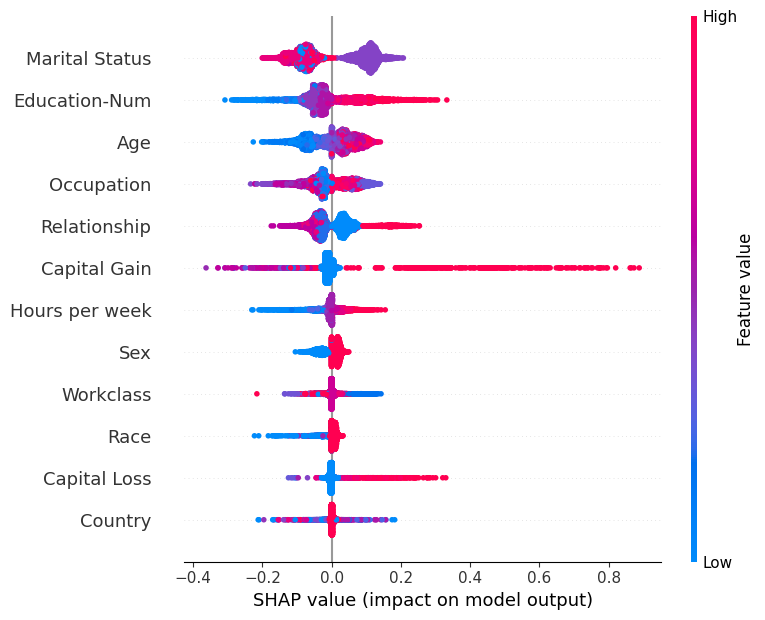

In [ ]:
feature_names = list(num_cols) + list(cat_cols)
shap.summary_plot(shap_values, X_test_combined, feature_names=feature_names)

In [ ]:
with open('saved_shap/fttransformer_shap_values_adults.pkl', 'wb') as f:
    pickle.dump(shap_values, f)


## Quantus

### Wrapped Model

In [ ]:
class FTModelWrapper(nn.Module):
    """
    Wraps an FTTransformer so that Quantus can call `.forward(x)` and `.predict(x)`,
    where x is a 2D numpy array of shape (batch_size, n_cont + n_cat). Internally,
    we split into numeric vs. categorical tensors and forward them to the FTTransformer.
    """
    def __init__(self, ft_model: nn.Module, cat_cardinalities):
        super(FTModelWrapper, self).__init__()
        self.model = ft_model
        self.model.eval()
        self.cat_cardinalities = cat_cardinalities  # Store cardinalities for clipping

    def _clip_categorical_indices(self, x_cat):
        """
        Clip categorical indices to valid ranges based on cardinalities.
        """
        x_cat_clipped = x_cat.clone()
        for i, cardinality in enumerate(self.cat_cardinalities):
            # Clip to valid range [0, cardinality-1]
            x_cat_clipped[:, i] = torch.clamp(x_cat_clipped[:, i], 0, cardinality - 1)
        return x_cat_clipped

    def forward(self, combined_x):
        """
        combined_x: torch.Tensor of shape (batch_size, n_cont + n_cat), dtype float or long.
        We'll split it into (X_num, X_cat).
        """
        # split along last dim
        Xn = combined_x[:, :n_cont].float().to(device)
        Xc = combined_x[:, n_cont:].long().to(device)

        # Clip categorical indices to valid ranges
        Xc = self._clip_categorical_indices(Xc)

        logits = self.model(Xn, Xc)  # shape (batch_size, 2)
        return logits

    def predict(self, combined_X):
        """
        combined_X: numpy array of shape (batch_size, n_cont + n_cat).
        Returns: probabilities (batch_size, 2).
        """
        self.model.eval()
        with torch.no_grad():
            # convert to torch
            t = torch.from_numpy(combined_X).float().to(device)
            logits = self.forward(t)  # shape (batch_size, 2)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
        return probs

    def shape_input(self, x: np.ndarray, shape, channel_first):
        """For Quantus: ensure x is at least 2D."""
        return np.atleast_2d(x)

# Update the instantiation to include cardinalities:
wrapped_model = FTModelWrapper(model, cat_cardinalities=cardinalities)
wrapped_model.eval()  # set to eval mode

FTModelWrapper(
  (model): FTTransformer(
    (cls_embedding): _CLSEmbedding()
    (cont_embeddings): LinearEmbeddings()
    (cat_embeddings): CategoricalEmbeddings(
      (embeddings): ModuleList(
        (0): Embedding(9, 32)
        (1): Embedding(7, 32)
        (2): Embedding(15, 32)
        (3): Embedding(6, 32)
        (4): Embedding(5, 32)
        (5): Embedding(2, 32)
        (6): Embedding(42, 32)
      )
    )
    (backbone): FTTransformerBackbone(
      (blocks): ModuleList(
        (0): ModuleDict(
          (attention): MultiheadAttention(
            (W_q): Linear(in_features=32, out_features=32, bias=True)
            (W_k): Linear(in_features=32, out_features=32, bias=True)
            (W_v): Linear(in_features=32, out_features=32, bias=True)
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (attention_residual_dropout): Dropout(p=0.0, inplace=False)
          (ffn_normalization): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (f

### Complexity

In [ ]:
# Apply Complexity metric using SHAP attributions
Complexity_shap = quantus.Complexity(
    normalise=False,
    abs=True,  # Take absolute values of attributions
    disable_warnings=True,
    display_progressbar=True,
    aggregate_func=np.mean,  # Compute mean complexity over all samples
)(
    model=wrapped_model,
    x_batch=X_test_combined,
    y_batch=y_test_int,
    a_batch=shap_values,   # use SHAP attributions computed above
    explain_func=None      # explanations are precomputed
)

# Scale to 0-1
Complexity_shap = (Complexity_shap - min(Complexity_shap)) / (
    max(Complexity_shap) - min(Complexity_shap)
)

# Find mean
Complexity_shap = np.mean(Complexity_shap)

print(
    f"Complexity: Complexity by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    Complexity_shap,
)

  0%|          | 0/102.0 [00:00<?, ?it/s]

Complexity: Complexity by Bhatt et al., 2020.

 • SHAP =  0.6654540802771639


In [ ]:
Sparseness_shap = quantus.Sparseness(
    normalise=False,
    abs=True, # take absolute values of attributions
    disable_warnings=True,
    display_progressbar=True,
    return_aggregate=True, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
)(
    model=wrapped_model,
    x_batch=X_test_combined,
    y_batch=y_test_int,
    a_batch=shap_values,   # use SHAP attributions computed above
    explain_func=None      # explanations are precomputed
)

# Already scaled to 0-1 -> keep aggregated (mean)

print(
    f"Complexity: Sparseness by Chalasani et al., 2020.\n"
    f"\n • SHAP = ",
    Sparseness_shap,
)

  0%|          | 0/102.0 [00:00<?, ?it/s]

Complexity: Sparseness by Chalasani et al., 2020.

 • SHAP =  [np.float64(0.53109050285768)]


### Faithfulness

In [ ]:
FaithfulnessCorrelation_shap = quantus.FaithfulnessCorrelation(
    perturb_baseline="white",
    perturb_func=quantus.baseline_replacement_by_indices,
    subset_size=5, # features to perturb
    nr_runs=10,
    similarity_func=quantus.similarity_func.correlation_pearson,
    abs=True, # take absolute values of attributions
    normalise=False, # do not normalise ohe data
    return_aggregate=False, # (not) output 1 val instead of list of vals for all samples
    aggregate_func=np.mean,
    disable_warnings=True,
    display_progressbar=True,
)(
    model=wrapped_model,
    x_batch=X_test_combined,
    y_batch=y_test_int,
    a_batch=shap_values,   # use SHAP attributions computed above
    explain_func=None,      # explanations are precomputed
    device=device
)

# Scale to 0-1
FaithfulnessCorrelation_shap = (FaithfulnessCorrelation_shap - np.min(FaithfulnessCorrelation_shap)) / (
    np.max(FaithfulnessCorrelation_shap) - np.min(FaithfulnessCorrelation_shap)
)

# Find mean
FaithfulnessCorrelation_shap = np.mean(FaithfulnessCorrelation_shap)

print(
    f"Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    FaithfulnessCorrelation_shap,
)

In [ ]:
FaithfulnessEstimate_shap = quantus.FaithfulnessEstimate(
    perturb_baseline="white",
    perturb_func=quantus.baseline_replacement_by_indices,
    features_in_step=1, # features to perturb
    similarity_func=quantus.similarity_func.correlation_pearson,
    abs=True, # take absolute values of attributions
    normalise=False, # do not normalise ohe data
    return_aggregate=False, # (not) output 1 val instead of list of vals for all samples
    aggregate_func=np.mean,
    disable_warnings=True,
    display_progressbar=True,
)(
    model=wrapped_model,
    x_batch=X_test_combined,
    y_batch=y_test_int,
    a_batch=shap_values,   # use SHAP attributions computed above
    explain_func=None,      # explanations are precomputed
    device=device
)

# Scale to 0-1
FaithfulnessEstimate_shap = (FaithfulnessEstimate_shap - np.min(FaithfulnessEstimate_shap)) / (
    np.max(FaithfulnessEstimate_shap) - np.min(FaithfulnessEstimate_shap)
)

# Find mean
FaithfulnessEstimate_shap = np.mean(FaithfulnessEstimate_shap)

print(
    f"Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    FaithfulnessEstimate_shap,
)

  0%|          | 0/102.0 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/quantus/helpers/warn.py:257: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.5356530241290733


In [ ]:

# FaithfulnessCorrelation_shap = quantus.FaithfulnessCorrelation(
#     perturb_baseline="white",
#     perturb_func=quantus.baseline_replacement_by_indices,
#     subset_size=5,                           # number of features to perturb per run
#     nr_runs=10,                              # how many random subsets to try
#     similarity_func=quantus.similarity_func.correlation_pearson,
#     abs=True,
#     normalise=False,
#     return_aggregate=False,                  # get one value per test sample
#     aggregate_func=np.mean,
#     disable_warnings=True,
#     display_progressbar=True,
# )(
#     model=wrapped_model,
#     x_batch=X_test_combined,
#     y_batch=y_test_int,
#     a_batch=shap_values,
#     explain_func=None
# )

# # scale to [0,1], then take the mean
# fc = np.array(FaithfulnessCorrelation_shap)
# fc = (fc - np.min(fc)) / (np.max(fc) - np.min(fc))
# FaithfulnessCorrelation_shap = float(np.mean(fc))

# print("FaithfulnessCorrelation (Bhatt et al., 2020) [SHAP]:", round(FaithfulnessCorrelation_shap, 4))


  0%|          | 0/102.0 [00:00<?, ?it/s]

FaithfulnessCorrelation (Bhatt et al., 2020) [SHAP]: 0.5438


In [ ]:
# FaithfulnessEstimate_shap = quantus.FaithfulnessEstimate(
#     perturb_baseline="white",
#     perturb_func=quantus.baseline_replacement_by_indices,
#     features_in_step=1,                      # remove one feature at a time
#     similarity_func=quantus.similarity_func.correlation_pearson,
#     abs=True,
#     normalise=False,
#     return_aggregate=False,
#     aggregate_func=np.mean,
#     disable_warnings=True,
#     display_progressbar=True,
# )(
#     model=wrapped_model,
#     x_batch=X_test_combined,
#     y_batch=y_test_int,
#     a_batch=shap_values,
#     explain_func=None,
#     device=device,
# )

# fe = FaithfulnessEstimate_shap
# fe = (fe - np.min(fe)) / (np.max(fe) - np.min(fe))
# FaithfulnessEstimate_shap = float(np.mean(fe))

# print("FaithfulnessEstimate (Alvarez-Melis et al., 2018) [SHAP]:", round(FaithfulnessEstimate_shap, 4))

  0%|          | 0/102.0 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/quantus/helpers/warn.py:257: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


FaithfulnessEstimate (Alvarez-Melis et al., 2018) [SHAP]: 0.5981


### Robustness

In [ ]:
LocalLipschitzEstimate_shap = quantus.LocalLipschitzEstimate(
    normalise=False,
    abs=True, # take absolute values of attributions
    nr_samples = 20,
    disable_warnings=True,
    display_progressbar=True,
    # return_aggregate=True, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
)(
    model=wrapped_model,
    x_batch=X_test_combined,
    y_batch=y_test_int,
    # a_batch=shap_values,   # use SHAP attributions computed above
    # explain_func=None      # explanations are precomputed
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "DeepLiftShap", "reduce_axes": ()},
    device=device
)

# Scale to 0-1
LocalLipschitzEstimate_shap = (LocalLipschitzEstimate_shap - np.min(LocalLipschitzEstimate_shap)) / (
    np.max(LocalLipschitzEstimate_shap) - np.min(LocalLipschitzEstimate_shap)
)

# Find mean
LocalLipschitzEstimate_shap = np.mean(LocalLipschitzEstimate_shap)

print(
    f"Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    LocalLipschitzEstimate_shap,
)

  0%|          | 0/102.0 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.101544417298378


In [ ]:
# LocalLipschitzEstimate_shap = quantus.LocalLipschitzEstimate(
#     normalise=False,
#     abs=True,
#     nr_samples=20,
#     disable_warnings=True,
#     display_progressbar=True,
#     aggregate_func=np.mean
# )(
#     model=wrapped_model,
#     x_batch=X_test_combined,
#     y_batch=y_test_int,
#     a_batch=None,
#     explain_func=quantus.explain,
#     explain_func_kwargs={"method": "DeepLiftShap", "reduce_axes": ()},
#     device=device,
# )

# lle = LocalLipschitzEstimate_shap
# lle = (lle - np.min(lle)) / (np.max(lle) - np.min(lle))
# LocalLipschitzEstimate_shap = float(np.mean(lle))

# print("LocalLipschitzEstimate (Alvarez-Melis et al., 2018) [SHAP]:", round(LocalLipschitzEstimate_shap, 4))

  0%|          | 0/102.0 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


LocalLipschitzEstimate (Alvarez-Melis et al., 2018) [SHAP]: 0.1267


### Randomisation

In [ ]:
RandomLogit_shap = quantus.RandomLogit(
    num_classes=2,
    disable_warnings=True,
    normalise=False,
    abs=True, # take absolute values of attributions
    display_progressbar=True,
    return_aggregate=False, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
)(
    model=wrapped_model,
    x_batch=X_test_combined,
    y_batch=y_test_int,
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "GradientShap", "reduce_axes": ()},
    device=device
)


print(
    f"Randomisation: RandomLogit scores by Sixt et al., 2020.\n"
    f"\n • SHAP = ",
    RandomLogit_shap,
)

print(np.min(RandomLogit_shap))

print(np.max(RandomLogit_shap))

# Scale to 0-1
RandomLogit_shap = (RandomLogit_shap - np.min(RandomLogit_shap)) / (
    np.max(RandomLogit_shap) - np.min(RandomLogit_shap)
)

# Find mean
RandomLogit_shap = np.mean(RandomLogit_shap)

print(
    f"Randomisation: RandomLogit scores by Sixt et al., 2020.\n"
    f"\n • SHAP = ",
    RandomLogit_shap,
)

  0%|          | 0/102.0 [00:00<?, ?it/s]

Randomisation: RandomLogit scores by Sixt et al., 2020.

 • SHAP =  [np.float64(0.4079401319225629), np.float64(0.5323959439992905), np.float64(0.7075240711371104), np.float64(0.33876803641517955), np.float64(0.40165865421295166), np.float64(0.246271762996912), np.float64(0.938524087270101), np.float64(0.3443850303689639), np.float64(0.33062151571114856), np.float64(0.30904316032926243), np.float64(0.5972169389327368), np.float64(0.2479744137575229), np.float64(0.37144722789525986), np.float64(0.4504198183616002), np.float64(0.3914627929528554), np.float64(0.23006272804923356), np.float64(0.7656701604525248), np.float64(0.6936181286970774), np.float64(0.5604483137528101), np.float64(0.3561895738045375), np.float64(0.22676706997056803), np.float64(0.18063064365560422), np.float64(0.6333277920881907), np.float64(0.21469407342374325), np.float64(0.3182353871234227), np.float64(0.7580430010954539), np.float64(0.2165386943767468), np.float64(0.8043463130791982), np.float64(0.379445157324274

In [ ]:
MPRT_shap = quantus.MPRT(
    # similarity_func=quantus.similarity_func.correlation_spearman,
    return_average_correlation=True,
    # return_aggregate=True, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
    layer_order="independent",
    similarity_func=quantus.ssim,
    disable_warnings=True,
    normalise=False,
    abs=True, # take absolute values of attributions
    display_progressbar=True,
)(
    model=wrapped_model,
    x_batch=X_test_combined,
    y_batch=y_test_int,
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "GradientShap", "reduce_axes": ()},
    device=device
)

# Scale to 0-1
MPRT_shap = (MPRT_shap - np.min(MPRT_shap)) / (
    np.max(MPRT_shap) - np.min(MPRT_shap)
)

# Find mean
MPRT_shap = np.mean(MPRT_shap)

print(
    f"Randomisation: MPRT scores by Adebayo et al., 2018\n"
    f"\n • SHAP = ",
    MPRT_shap,
)

  0%|          | 0/208416 [00:00<?, ?it/s]

Randomisation: MPRT scores by Adebayo et al., 2018

 • SHAP =  0.5430458995443038


### Summary old

In [ ]:
# # display(Markdown("#### Explanability scores"))

# print("Complexity:", round((Complexity_shap + Sparseness_shap) / 2, 4))
# print("Faithfulness:", round((FaithfulnessEstimate_shap + FaithfulnessCorrelation_shap) / 2, 4))
# print("Robustness:", round(LocalLipschitzEstimate_shap, 4))
# print("Randomisation:", round((MPRT_shap + RandomLogit_shap) / 2, 4))

Complexity: 0.6759
Faithfulness: 0.571
Robustness: 0.1267
Randomisation: 0.5461


### Summary (all)

In [ ]:
# Convert from list to int
Complexity_shap = np.float64(Complexity_shap)
Sparseness_shap = np.float64(Sparseness_shap)
MPRT_shap = np.float64(MPRT_shap)
RandomLogit_shap = np.float64(RandomLogit_shap)
FaithfulnessEstimate_shap = np.float64(FaithfulnessEstimate_shap)
FaithfulnessCorrelation_shap = np.float64(FaithfulnessCorrelation_shap)
LocalLipschitzEstimate_shap = np.float64(LocalLipschitzEstimate_shap)

# Rounding one by one
Complexity_shap = round(float(Complexity_shap), 4)
Sparseness_shap = round(float(Sparseness_shap), 4)
MPRT_shap = round(float(MPRT_shap), 4)
RandomLogit_shap = round(float(RandomLogit_shap), 4)
FaithfulnessEstimate_shap = round(float(FaithfulnessEstimate_shap), 4)
FaithfulnessCorrelation_shap = round(float(FaithfulnessCorrelation_shap), 4)
LocalLipschitzEstimate_shap = round(float(LocalLipschitzEstimate_shap), 4)

<ipython-input-28-acd3cc85ebb0>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sparseness_shap = round(float(Sparseness_shap), 4)


In [ ]:


# Complexity: Complexity
print(
    f"Complexity: Complexity by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    Complexity_shap,
)

# Complexity: Sparseness
print(
    f"Complexity: Sparseness by Chalasani et al., 2020.\n"
    f"\n • SHAP = ",
    Sparseness_shap,
)

# Faithfulness: Faithfulness Estimate
print(
    f"Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    FaithfulnessEstimate_shap,
)

# Faithfulness: Faithfulness Correlation
print(
    f"Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    FaithfulnessCorrelation_shap,
)

# Robustness: Local Lipschitz Estimate
print(
    f"Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    LocalLipschitzEstimate_shap,
)

# Randomisation: MPRT
print(
    f"Randomisation: MPRT scores by Adebayo et al., 2018\n"
    f"\n • SHAP = ",
    MPRT_shap,
)

# Randomisation: RandomLogit
print(
    f"Randomisation: RandomLogit scores by Sixt et al., 2020.\n"
    f"\n • SHAP = ",
    RandomLogit_shap,
)

Complexity: Complexity by Bhatt et al., 2020.

 • SHAP =  0.6655
Complexity: Sparseness by Chalasani et al., 2020.

 • SHAP =  0.5311
Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.5357
Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.

 • SHAP =  0.5445
Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.1015
Randomisation: MPRT scores by Adebayo et al., 2018

 • SHAP =  0.543
Randomisation: RandomLogit scores by Sixt et al., 2020.

 • SHAP =  0.4239


### Summary

In [ ]:


# Complexity: Complexity and Sparseness
print(
    f"Complexity"
    f"\n • SHAP = ",
    round(float((Complexity_shap+Sparseness_shap)/2), 4),
)

# Faithfulness: Faithfulness Estimate and Faithfulness Correlation
print(
    f"Faithfulness"
    f"\n • SHAP = ",
    round(float((FaithfulnessEstimate_shap+FaithfulnessCorrelation_shap)/2), 4),
)

# Robustness: Local Lipschitz Estimate
print(
    f"Robustness"
    f"\n • SHAP = ",
    round(float((LocalLipschitzEstimate_shap)), 4),
)

# Randomisation: MPRT and RandomLogit
print(
    f"Randomisation"
    f"\n • SHAP = ",
    round(float((MPRT_shap+RandomLogit_shap)/2), 4)
)

Complexity
 • SHAP =  0.5983
Faithfulness
 • SHAP =  0.5401
Robustness
 • SHAP =  0.1015
Randomisation
 • SHAP =  0.4835
